In [6]:
import os
import numpy as np
from keras.applications import VGG16
from keras.preprocessing.image import ImageDataGenerator
from keras import models, layers, optimizers
import matplotlib.pyplot as plt

In [7]:
conv_base = VGG16(weights='imagenet',
                  include_top=False,
                  input_shape=(150,150,3))

In [8]:
conv_base.summary()

Model: "vgg16"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         [(None, 150, 150, 3)]     0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 150, 150, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 150, 150, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 75, 75, 64)        0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 75, 75, 128)       73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 75, 75, 128)       147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 37, 37, 128)       0     

In [9]:
from google.colab import drive
drive.mount('/content/gdrive')
%cd /content/gdrive/My Drive/Kaggle

Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).
/content/gdrive/My Drive/Kaggle


In [14]:
base_dir = 'cats_and_dogs_small' 

train_dir = os.path.join(base_dir, 'train')
validation_dir = os.path.join(base_dir, 'validation')
test_dir = os.path.join(base_dir, 'test')

datagen = ImageDataGenerator(rescale=1./255)
batch_size = 20

def extract_features(dir, sample_count):
  features = np.zeros(shape=(sample_count, 4, 4, 512))
  labels = np.zeros(shape=(sample_count))
  generator = datagen.flow_from_directory(
      dir,
      target_size=(150,150),
      batch_size=batch_size,
      class_mode='binary'
  )
  i=0
  for inputs_batch, labels_batch in generator:
    features_batch = conv_base.predict(inputs_batch)
    features[i*batch_size:(i+1)*batch_size] = features_batch
    labels[i*batch_size:(i+1)*batch_size] = labels_batch
    i+=1
    if i*batch_size >= sample_count:
      break
  return features, labels

train_featuures, train_labels = extract_features(train_dir, 2000)
validation_features, validation_labels = extract_features(validation_dir, 1000)
test_features, test_labels = extract_features(test_dir, 1000)

Found 2000 images belonging to 2 classes.
Found 1000 images belonging to 2 classes.
Found 1000 images belonging to 2 classes.


In [16]:
train_features = np.reshape(train_featuures, (2000, 4*4*512))
validation_features = np.reshape(validation_features, (1000, 4*4*512))
test_features = np.reshape(test_features, (1000, 4*4*512))

In [17]:
model = models.Sequential()

model.add(layers.Dense(256, activation='relu', input_dim=4*4*512))
model.add(layers.Dropout(0.5))
model.add(layers.Dense(1, activation='sigmoid'))

model.compile(optimizer=optimizers.RMSprop(lr=2e-5),
              loss='binary_crossentropy',
              metrics=['acc'])

history = model.fit(train_features, train_labels, epochs=30, batch_size=20, validation_data=(validation_features, validation_labels))

Epoch 1/30
100/100 [==============================] - 0s 5ms/step - loss: 0.6199 - acc: 0.6505 - val_loss: 0.4623 - val_acc: 0.8220
Epoch 2/30
100/100 [==============================] - 0s 4ms/step - loss: 0.4418 - acc: 0.8040 - val_loss: 0.3772 - val_acc: 0.8490
Epoch 3/30
100/100 [==============================] - 0s 4ms/step - loss: 0.3563 - acc: 0.8595 - val_loss: 0.3339 - val_acc: 0.8720
Epoch 4/30
100/100 [==============================] - 0s 4ms/step - loss: 0.3175 - acc: 0.8680 - val_loss: 0.3098 - val_acc: 0.8750
Epoch 5/30
100/100 [==============================] - 0s 4ms/step - loss: 0.2946 - acc: 0.8805 - val_loss: 0.3050 - val_acc: 0.8820
Epoch 6/30
100/100 [==============================] - 0s 3ms/step - loss: 0.2695 - acc: 0.8980 - val_loss: 0.2781 - val_acc: 0.8880
Epoch 7/30
100/100 [==============================] - 0s 4ms/step - loss: 0.2498 - acc: 0.9035 - val_loss: 0.2696 - val_acc: 0.8960
Epoch 8/30
100/100 [==============================] - 0s 3ms/step - loss: 0.

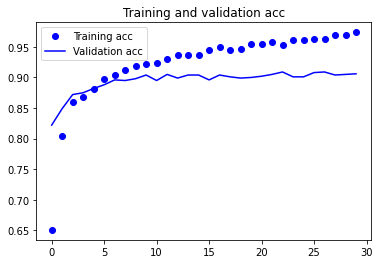

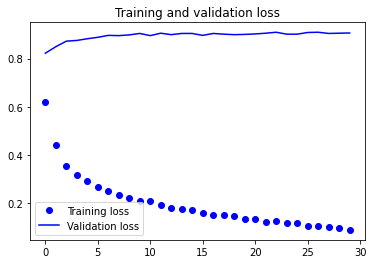

In [20]:
acc = history.history['acc']
val_acc = history.history['val_acc']
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(len(acc))

plt.plot(epochs, acc, 'bo', label='Training acc')
plt.plot(epochs, val_acc, 'b', label='Validation acc')
plt.title('Training and validation acc')
plt.legend()
plt.figure()

plt.plot(epochs, loss, 'bo', label='Training loss')
plt.plot(epochs, val_acc, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.legend()
plt.show()

In [21]:
model = models.Sequential()
model.add(conv_base)
model.add(layers.Flatten())
model.add(layers.Dense(256, activation='relu'))
model.add(layers.Dense(1, activation='sigmoid'))
model.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
vgg16 (Functional)           (None, 4, 4, 512)         14714688  
_________________________________________________________________
flatten (Flatten)            (None, 8192)              0         
_________________________________________________________________
dense_2 (Dense)              (None, 256)               2097408   
_________________________________________________________________
dense_3 (Dense)              (None, 1)                 257       
Total params: 16,812,353
Trainable params: 16,812,353
Non-trainable params: 0
_________________________________________________________________


In [24]:
conv_base.trainable = False
model.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
vgg16 (Functional)           (None, 4, 4, 512)         14714688  
_________________________________________________________________
flatten (Flatten)            (None, 8192)              0         
_________________________________________________________________
dense_2 (Dense)              (None, 256)               2097408   
_________________________________________________________________
dense_3 (Dense)              (None, 1)                 257       
Total params: 16,812,353
Trainable params: 2,097,665
Non-trainable params: 14,714,688
_________________________________________________________________


In [26]:
train_datagen = ImageDataGenerator(
    rescale=1./255,
    rotation_range=40,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    fill_mode='nearest'
)

test_datagen = ImageDataGenerator(
    rescale=1./255
)

train_generator = train_datagen.flow_from_directory(
    train_dir,
    target_size=(150,150),
    batch_size=20,
    class_mode='binary'
)

validation_generator = test_datagen.flow_from_directory(
    validation_dir,
    target_size=(150,150),
    batch_size=20,
    class_mode='binary'
)

model.compile(loss='binary_crossentropy',
              optimizer=optimizers.RMSprop(lr=2e-5),
              metrics=['acc'])

history = model.fit(train_generator,
                    epochs=30,
                    validation_data=validation_generator,
                    verbose=2)

Found 2000 images belonging to 2 classes.
Found 1000 images belonging to 2 classes.
Epoch 1/30
100/100 - 20s - loss: 0.5824 - acc: 0.7115 - val_loss: 0.4585 - val_acc: 0.8000
Epoch 2/30
100/100 - 20s - loss: 0.4739 - acc: 0.7930 - val_loss: 0.3648 - val_acc: 0.8640
Epoch 3/30
100/100 - 20s - loss: 0.4296 - acc: 0.8100 - val_loss: 0.3300 - val_acc: 0.8780
Epoch 4/30
100/100 - 20s - loss: 0.3990 - acc: 0.8290 - val_loss: 0.3146 - val_acc: 0.8810
Epoch 5/30
100/100 - 20s - loss: 0.3892 - acc: 0.8240 - val_loss: 0.2907 - val_acc: 0.8830
Epoch 6/30
100/100 - 20s - loss: 0.3616 - acc: 0.8480 - val_loss: 0.2910 - val_acc: 0.8800
Epoch 7/30
100/100 - 20s - loss: 0.3583 - acc: 0.8430 - val_loss: 0.2781 - val_acc: 0.8880
Epoch 8/30
100/100 - 20s - loss: 0.3531 - acc: 0.8430 - val_loss: 0.2761 - val_acc: 0.8860
Epoch 9/30
100/100 - 20s - loss: 0.3408 - acc: 0.8560 - val_loss: 0.2625 - val_acc: 0.8940
Epoch 10/30
100/100 - 20s - loss: 0.3241 - acc: 0.8630 - val_loss: 0.2578 - val_acc: 0.8970
Epoch

In [26]:
model.save('cats_and_dogs_small_3.h5')

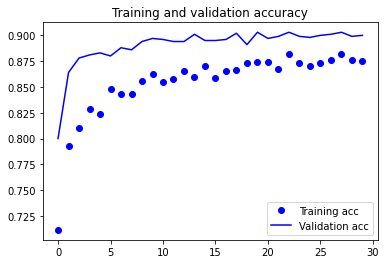

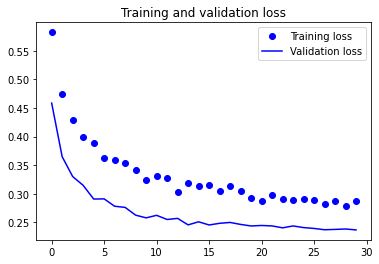

In [27]:
acc = history.history['acc']
val_acc = history.history['val_acc']
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(len(acc))

plt.plot(epochs, acc, 'bo', label='Training acc')
plt.plot(epochs, val_acc, 'b', label='Validation acc')
plt.title('Training and validation accuracy')
plt.legend()

plt.figure()

plt.plot(epochs, loss, 'bo', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.legend()

plt.show()

In [28]:
conv_base.trainable = True
isTrainable = False
for layer in conv_base.layers:
  if layer.name == 'block5_conv1':
    isTrainable = True
  layer.trainable = isTrainable

In [29]:
model.compile(loss='binary_crossentropy',
              optimizer=optimizers.RMSprop(lr=1e-5),
              metrics=['acc'])

history = model.fit(train_generator,
                    epochs=100,
                    validation_data=validation_generator,
                    verbose=2)

Epoch 1/100
100/100 - 21s - loss: 0.2996 - acc: 0.8615 - val_loss: 0.2429 - val_acc: 0.9050
Epoch 2/100
100/100 - 21s - loss: 0.2656 - acc: 0.8825 - val_loss: 0.2051 - val_acc: 0.9100
Epoch 3/100
100/100 - 21s - loss: 0.2316 - acc: 0.9030 - val_loss: 0.2089 - val_acc: 0.9240
Epoch 4/100
100/100 - 21s - loss: 0.2328 - acc: 0.9015 - val_loss: 0.1883 - val_acc: 0.9290
Epoch 5/100
100/100 - 21s - loss: 0.2065 - acc: 0.9125 - val_loss: 0.1898 - val_acc: 0.9230
Epoch 6/100
100/100 - 21s - loss: 0.1865 - acc: 0.9205 - val_loss: 0.1862 - val_acc: 0.9280
Epoch 7/100
100/100 - 21s - loss: 0.1919 - acc: 0.9210 - val_loss: 0.2087 - val_acc: 0.9140
Epoch 8/100
100/100 - 21s - loss: 0.1871 - acc: 0.9265 - val_loss: 0.1916 - val_acc: 0.9290
Epoch 9/100
100/100 - 20s - loss: 0.1734 - acc: 0.9240 - val_loss: 0.2198 - val_acc: 0.9190
Epoch 10/100
100/100 - 21s - loss: 0.1723 - acc: 0.9280 - val_loss: 0.1801 - val_acc: 0.9300
Epoch 11/100
100/100 - 21s - loss: 0.1539 - acc: 0.9410 - val_loss: 0.1748 - va

In [30]:
model.save('cats_and_dogs_small_4.h5')

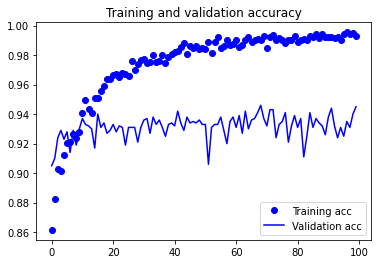

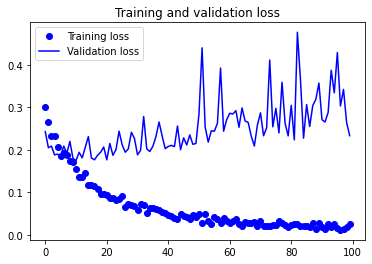

In [31]:
acc = history.history['acc']
val_acc = history.history['val_acc']
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(len(acc))

plt.plot(epochs, acc, 'bo', label='Training acc')
plt.plot(epochs, val_acc, 'b', label='Validation acc')
plt.title('Training and validation accuracy')
plt.legend()

plt.figure()

plt.plot(epochs, loss, 'bo', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.legend()

plt.show()

In [32]:
test_generator = test_datagen.flow_from_directory(
    test_dir,
    target_size=(150,150),
    batch_size=20,
    class_mode='binary'
)

test_loss, test_acc = model.evaluate(test_generator,verbose=2)

Found 1000 images belonging to 2 classes.
50/50 - 4s - loss: 0.3158 - acc: 0.9440
